In [16]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [17]:
# Modelo de atmósfera exponencial
def densidad(h, rho0, H):
    """
    Ecuación:
        ρ(h) = ρ₀ * exp(-h/H)
    donde:
        - ρ(h)  : densidad del aire a la altura h
        - ρ₀    : densidad del aire al nivel del mar (kg/m³)
        - H     : altura de escala (m)
        - h     : altura sobre el nivel del mar (m)
    parametros:

    h: Es la altura (en metros) sobre el nivel del mar.
    rho0: Es la densidad del aire al nivel del mar (Valor estándar: 1.225 kg/m³ (atmósfera estándar a 15 °C y 1 atm de presión))
    H: Es la altura de escala atmosférica (en metros). En la Tierra, H ≈ 8000 m (8 km) en la atmósfera estándar.
    """
    h_seguro = np.maximum(h, 0.0)
    return rho0 * np.exp(-h_seguro / H)

# Función principal de simulación
def simular_meteorito(masa, diametro, v0, h0,
                      Cd=1.0, rho0=1.225, H=8000.0,
                      t_max=20000.0, paso_max=0.5,
                      mostrar_graficas=True):
    """
    Simula la caída vertical  de un meteorito con arrastre atmosférico.
    Ecuaciones diferenciales del movimiento:

    1) Ecuación de la fuerza total:
       m * dv/dt = m*g - (1/2) * Cd * ρ(h) * A * v²

    2) Relación altura - velocidad:
       dh/dt = -v

    donde:
       - m   : masa del meteorito (kg)
       - g   : aceleración de la gravedad (9.81 m/s²)
       - Cd  : coeficiente de arrastre aerodinámico
       - ρ(h): densidad del aire a la altura h (kg/m³)
       - A   : área transversal = π*(d/2)² (m²)
       - v   : velocidad hacia abajo (m/s)
       - h   : altura sobre el nivel del suelo (m)
    Parámetros:

      masa: kg
      diametro: m
      v0: velocidad inicial hacia abajo (m/s)
      h0: altura inicial (m)
      Cd: coeficiente de arrastre. Valor ~1 es típico para objetos grandes irregulares a velocidades supersónicas.
      t_max : (20 000 segundos ≈ 5.5 horas) para asegurar que cualquier meteorito tenga tiempo suficiente para caer.
      paso_max: Es un control de precisión. 0.5 s da un buen balance entre exactitud y velocidad de cálculo
      rho0: densidad a nivel del mar (kg/m³)
      H: altura de escala (m)
    """

    g = 9.81
    area = np.pi * (diametro/2.0)**2

    def sistema(t, y):

        v, h = y
        if h <= 0:
            return [0.0, 0.0]

        rho = densidad(h, rho0, H) # densidad atmosférica según la altura
        # Fuerza de arrastre:
        # Fd = (1/2) * Cd * ρ(h) * A * v^2
        # Aceleración de arrastre = Fd / m
        arrastre = 0.5 * Cd * rho * area * v * abs(v) / masa
        dvdt = g - arrastre # dv/dt = g - (Fd/m)
        dhdt = -v
        return [dvdt, dhdt]

    def evento_impacto(t, y):

        return y[1] # condición: h = 0
    evento_impacto.terminal = True
    evento_impacto.direction = -1

    y0 = [v0, h0] # Condiciones iniciales: v = v0, h = h0
    sol = solve_ivp(sistema, [0, t_max], y0,
                    events=evento_impacto,
                    max_step=paso_max,
                    rtol=1e-7, atol=1e-9)

    t, v, h = sol.t, sol.y[0], sol.y[1]

     # Determinar impacto
    if sol.t_events[0].size > 0:
        tiempo_impacto = sol.t_events[0][0]
        velocidad_impacto = np.interp(tiempo_impacto, t, v)
    else:
        tiempo_impacto = None
        velocidad_impacto = None

        # Energía cinética: Ec = (1/2) * m * v²

    energia_cinetica = 0.5 * masa * v**2
    energia_impacto = 0.5 * masa * velocidad_impacto**2 if velocidad_impacto else None

    print("\n--- Resultados ---")
    if tiempo_impacto:
        print(f"Tiempo hasta impacto: {tiempo_impacto:.2f} s")
        print(f"Velocidad de impacto: {velocidad_impacto:.2f} m/s "
              f"({velocidad_impacto/1000:.3f} km/s)")
        print(f"Energía cinética al impacto: {energia_impacto:.3e} J")
    else:
        print("El meteorito no alcanzó el suelo en el tiempo simulado.")


    if mostrar_graficas:

        # Velocidad vs tiempo
        plt.figure()
        plt.plot(t, v)
        if tiempo_impacto:
            plt.axvline(tiempo_impacto, ls="--", c="k", label="Impacto")
            plt.legend()
        plt.xlabel("Tiempo (s)")
        plt.ylabel("Velocidad (m/s)")
        plt.title("Velocidad vs Tiempo")
        plt.grid()
        plt.show()

        # Altura vs tiempo
        plt.figure()
        plt.plot(t, h)
        plt.xlabel("Tiempo (s)")
        plt.ylabel("Altura (m)")
        plt.title("Altura vs Tiempo")
        plt.grid()
        plt.show()

        # Velocidad vs altura
        plt.figure()
        plt.plot(h, v)
        plt.xlabel("Altura (m)")
        plt.ylabel("Velocidad (m/s)")
        plt.title("Velocidad vs Altura")
        plt.grid()
        plt.show()

        # Densidad vs altura
        plt.figure()
        hs = np.linspace(0, h.max(), 200)
        plt.plot(densidad(hs, rho0, H), hs)
        plt.xlabel("Densidad (kg/m³)")
        plt.ylabel("Altura (m)")
        plt.title("Perfil de densidad atmosférica")
        plt.gca().invert_yaxis()
        plt.grid()
        plt.show()

    return {
        "tiempo_impacto": tiempo_impacto,
        "velocidad_impacto": velocidad_impacto,
        "energia_impacto": energia_impacto
    }



--- Resultados ---
Tiempo hasta impacto: 5.30 s
Velocidad de impacto: 17010.78 m/s (17.011 km/s)
Energía cinética al impacto: 1.592e+15 J


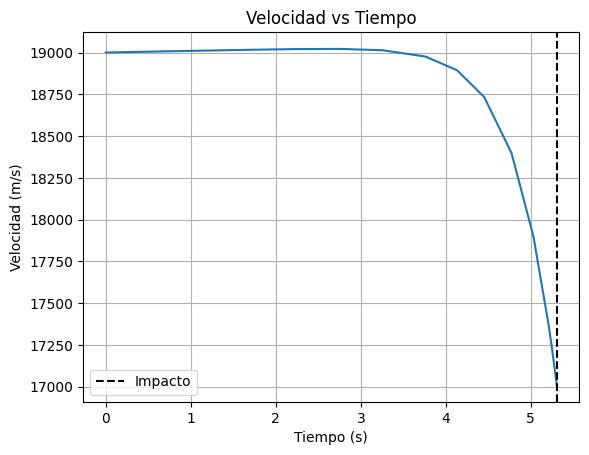

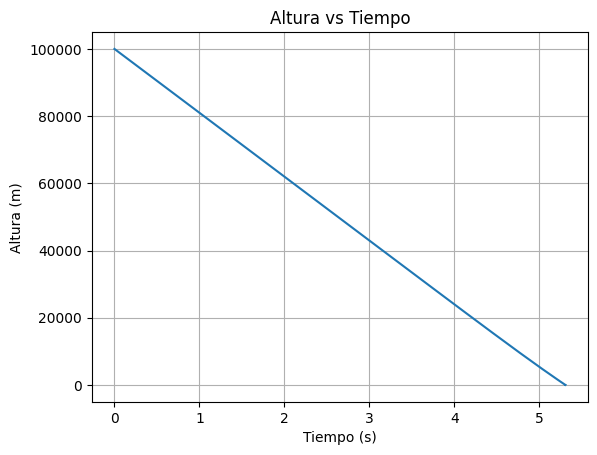

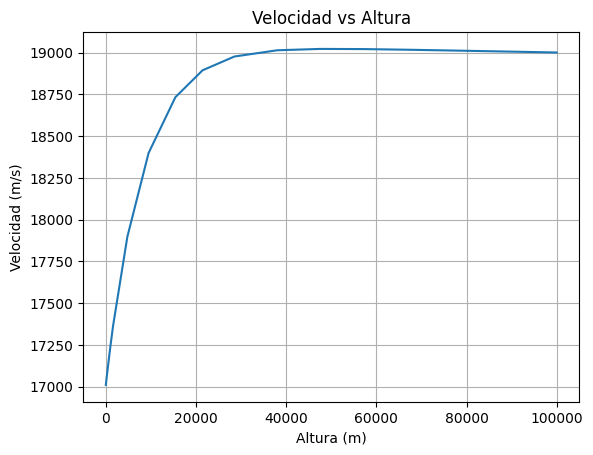

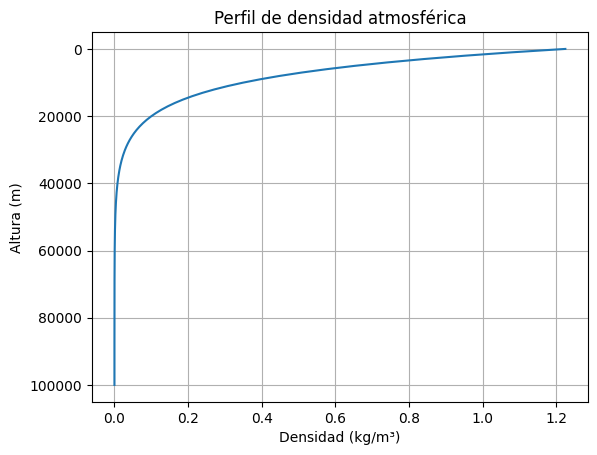

In [19]:
# Caso Chelyabinsk
res_chelyabinsk = simular_meteorito(
    masa=1.1e7,        # kg
    diametro=18.0,     # m
    v0=19000.0,        # m/s
    h0=100000.0,       # m
    Cd=1.0, rho0=1.225, H=8000.0
)

# https://es.wikipedia.org/wiki/B%C3%B3lido_de_Cheli%C3%A1binsk


--- Resultados ---
Tiempo hasta impacto: 3.77 s
Velocidad de impacto: 21421.75 m/s (21.422 km/s)
Energía cinética al impacto: 1.147e+16 J


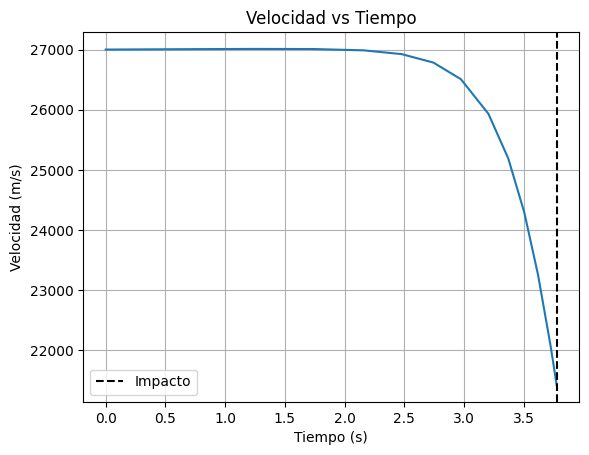

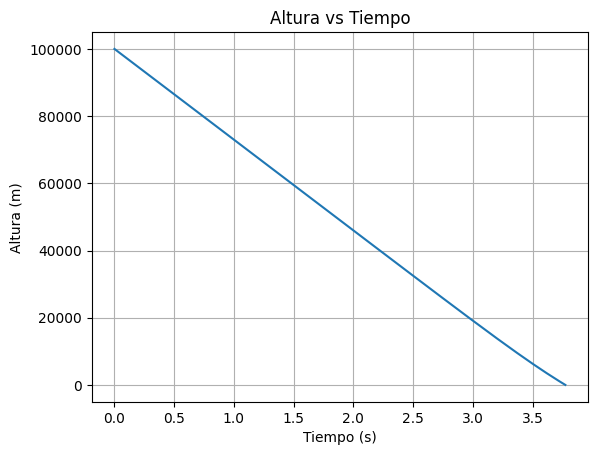

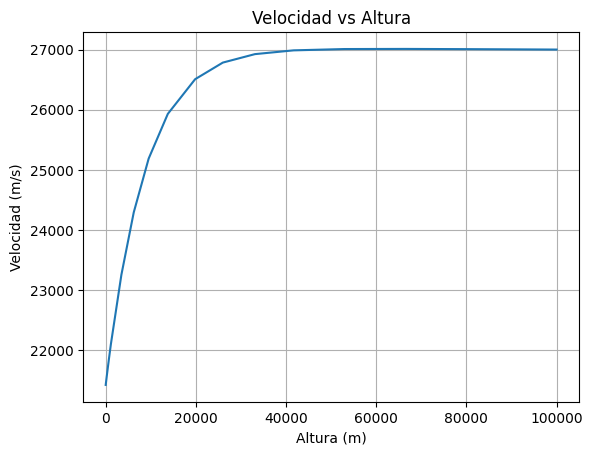

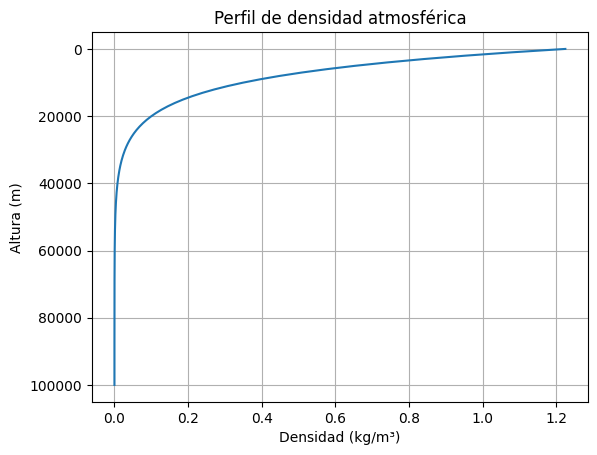

In [18]:
# Caso Tunguska
res_tunguska = simular_meteorito(
    masa=5e7,          # kg aprox.
    diametro=55.0,     # m
    v0=27000.0,        # m/s
    h0=100000.0,       # m
    Cd=1.0, rho0=1.225, H=8000.0
)
# https://es.wikipedia.org/wiki/B%C3%B3lido_de_Tunguska


--- Resultados ---
Tiempo hasta impacto: 8.31 s
Velocidad de impacto: 11908.56 m/s (11.909 km/s)
Energía cinética al impacto: 4.254e+16 J


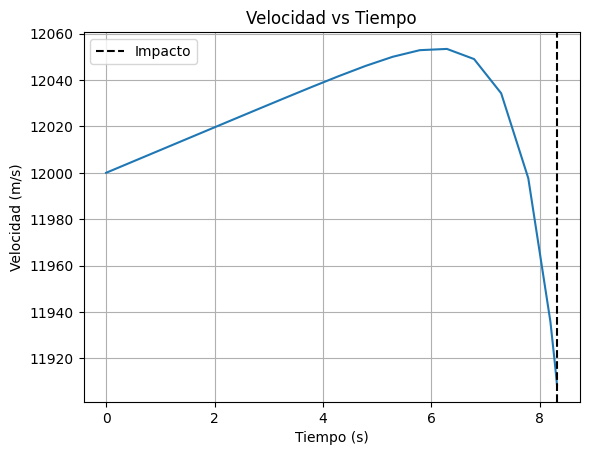

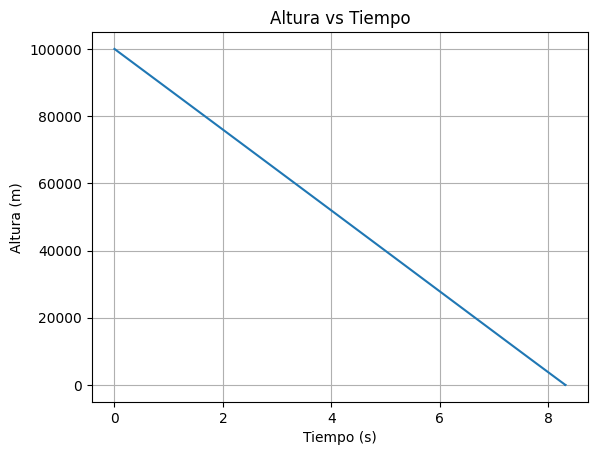

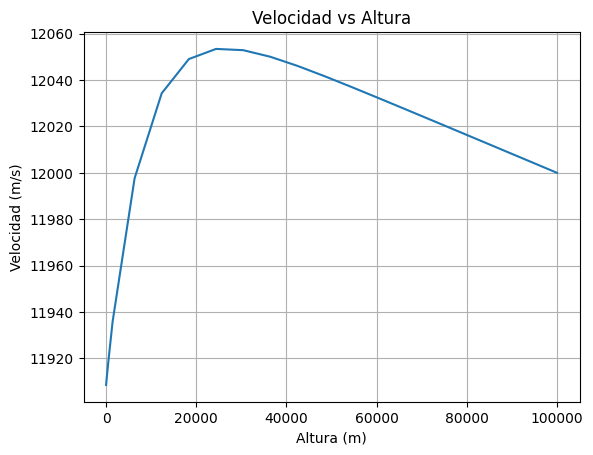

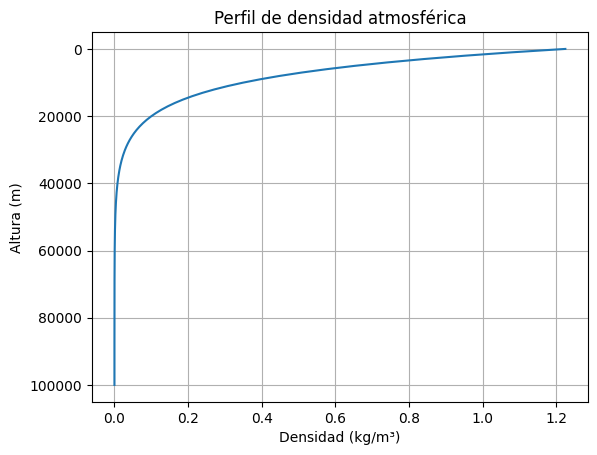

In [20]:
# Caso Crater Barringer
res_meteor_crater = simular_meteorito(
    masa=6e8,          # kg (hierro)
    diametro=50.0,     # m
    v0=12000.0,        # m/s
    h0=100000.0,       # m
    Cd=0.9, rho0=1.225, H=8000.0
)

# https://es.wikipedia.org/wiki/Cr%C3%A1ter_Barringer#:~:text=El%20cr%C3%A1ter%20Barringer%20%28en%20ingl%C3%A9s%3A%20%22Meteor%20Crater%22%29%2C%201,Unidos%2C%20siguiendo%20una%20salida%20de%20la%20interestatal%20I-40.